In [1]:
import numpy as np
import math

## Computer Experiments with Accelerated by Coupling Derivative-Free Method and Inexact Oracle

<i>Alexander Gasnikov</i> 
<br/>
<i>Moscow Institute of Physics and Technology  (Moscow, Russia)</i>
<br/>
<i>Eduard Gorbunov</i> 
<br/>
<i>Moscow Institute of Physics and Technology (Moscow, Russia)</i>
<br/>
<i>Pavel Dvurechensky</i>
<br/>
<i>Weierstrass Institute for Applied Analysis and Stochastics (Berlin, Germany)</i>
<br/>
<i>Evgeniya Vorontsova</i> 
<br/>
<i>Far Eastern Federal University (Vladivostok, Russia)</i>

Article: https://arxiv.org/abs/1710.00162 (in Russian)

For earlier explanations of formulas see also: https://github.com/JaneJaneVL/ACDS/blob/master/ACDSn10.ipynb

Let $A$ be a real random matrix $n \times n$ with elements from $[0, \, 1]$. 
$$
B = \frac{A^T A}{\lambda_{max}(A^T A)}, \quad x^* = (1, \, 0, \, 0, \, \ldots, \, 0). 
$$

Function to be minimized: $f = \frac{1}{2} \langle x - x^*, \, B(x - x^*) \rangle \, \rightarrow \, \min\limits_x$.


In [2]:
# Power iteration algorithm (eigenvalue algorithm)
def power_iteration(A, maxiter):
    
    b_k = np.random.rand(A.shape[0])
    
    for k in range(0, maxiter):
        # calculate the matrix-by-vector product Ab
        b_k1 = np.dot(A, b_k)

        # calculate the norm
        b_k1_norm = np.linalg.norm(b_k1)

        # re normalize the vector
        b_k = b_k1 / b_k1_norm

    return b_k

In [3]:
n = 10; # Dimension of vector space
x_star = np.zeros(n).reshape(n, 1);
x_star[0] = 1;

A = np.random.rand(n, n);
B = (A.T).dot(A);

# Find B eigenvector associated with the dominant eigenvalue
e_vect = power_iteration(B, 1000)

e_vect_tr = e_vect.reshape(1, e_vect.size)

# Rayleigh quotient
# Dominant eigenvalue of B
e_value = np.dot(e_vect_tr, np.dot(B, e_vect)) / np.dot(e_vect_tr, e_vect)

B = B / e_value
print(e_value)

[29.66530421]


In [4]:
f = lambda x: 1. / 2 * np.dot((x - x_star).T, np.dot(B, x - x_star))

In [5]:
#Initial point
x0 = np.zeros(n).reshape(n, 1);
x0[n-1] = 1;

L = 1

In [6]:
# Generating uniformly distributed numbers on a sphere
def get_rand_vec(dims):
    e = np.random.standard_normal(dims)
    e = e / np.linalg.norm(e)
    return e.reshape(n, 1)

In [7]:
# Dikhotomy method for one-dimensional minimization 
def dihot(func, xa, xb, eps, maxit, a, c):
    
    fa = func(xa, a, c)
    fb = func(xb, a, c)
    if fa*fb > 0:
        print("Error - Dihotomy can't work!")
    
    iter = 0
    while abs(xb-xa) > eps and iter < maxit:  
        xc = (xa+xb) / 2
        fc = func(xc, a, c)
        if fa*fc > 0:
            xa = xc
        else:
            xb = xc
            
        iter = iter + 1
    return xc

In [8]:
# Prox-function 
# z should be a vector, not a matrix (use np.ravel() to convert)
def d(z, a):
    norm_z = np.linalg.norm(z, a)
    return 1/ 2 / (a - 1) * norm_z* norm_z

In [9]:
#Gradient of prox-function 
def grad_d(z, a):
    g = np.zeros(n).reshape(n, 1)
    norm_z = np.linalg.norm(np.ravel(z), a)
    nzz = 1/ (a - 1)*pow(norm_z, 2 - a)
    for k in range(0, n):
        g[k] = nzz * pow(abs(z[k]), a - 1)
        
    return g

In [10]:
#Gradient G(lambda) 
def grad_G(lam, a, c):
    z = np.zeros(n).reshape(n, 1)
    g = np.zeros(n).reshape(n, 1)
    
    t = pow(lam * a * (a - 1), 2 / (2 - a))
    
    sum_z = 0
    for k in range(0, n):
        z[k] = pow( abs(- c[k] / lam / a), 1 / (a - 1))
        sum_z = sum_z + pow(z[k], a)
        
    g = pow(t, a / 2) - sum_z
    return g

In [11]:
eps = 1e-4

p = 1 + 1 / (2 * math.log(n))
q = p / (p - 1)

C_const = math.sqrt(3) * min([2*q - 1, 32* math.log(n) - 8]) * pow(n, 2/q + 1)

Vx0 = float(d(np.ravel(x_star), p) - d(np.ravel(x0), p) - grad_d(x0, p).T.dot(x_star - x0))

N1 = 4 * math.sqrt(Vx0 * L * C_const / eps)
delta = min(list([pow(eps, 1.5)/math.sqrt(Vx0*L*C_const), C_const*C_const*Vx0*L/n, eps*eps/n/Vx0/L]))
print("Number of iteration (required):", math.ceil(N1))
print("Upper bound for inexactness:", delta)

Number of iteration (required): 17215
Upper bound for inexactness: 2.1714724095162598e-10


In [12]:
def der_approx_f(x, t, e, func, noise):
    fxte = func(x+t*e, noise)
    fx = func(x, noise)
    r = (fxte-fx)/t
    return r*e

In [13]:
def approx_f(x, noise):
    return 1. / 2 * np.dot((x - x_star).T, np.dot(B, x - x_star)) + noise

### Method

In [14]:
k = 0

maxit = math.ceil(N1)

plt1 = []

noise = np.random.uniform(-delta, delta, 1)
f_star = approx_f(x_star, noise)

y0 = x0
z0 = x0

noise = np.random.uniform(-delta, delta, 1)
f_x = approx_f(x0, noise)
f_y = f_x

x = x0
z = z0
y = y0

while abs(f_y - f_star) > eps and k < maxit:
    tau = 2. / (k + 2)
    x = tau * z + (1 - tau) * y
    
    e = get_rand_vec(n)
    
    noise = np.random.uniform(-delta, delta, 1)
        
    t = 2*math.sqrt(abs(noise)/L)
    der_fxe = der_approx_f(x, t, e, approx_f, noise)     
        
    y = x - 1. / L * der_fxe;
        
    alpha = (k + 2) / 2 / L / C_const;
    
    c = alpha*n*der_fxe - grad_d(z, p)
    
    lam = dihot(grad_G, eps, 100, eps/10, maxit, p, c)
        
    for ii in range(0, n):
        z[ii] = pow( abs(- c[ii] / lam / p), 1 / (p - 1))
        
    f_y = f(y)
    plt1.append(abs(f_y[0][0]))
    
    if k%100 == 0:
        print("f_y", f_y, k, noise)
        
    k = k + 1
print(k, f_y)    

f_y [[0.01378529]] 0 [1.70483092e-10]
f_y [[0.01137019]] 100 [-2.00985428e-10]
f_y [[0.00895]] 200 [-7.36417555e-11]
f_y [[0.00745404]] 300 [1.37870788e-10]
f_y [[0.00553816]] 400 [2.13718138e-10]
f_y [[0.00446141]] 500 [1.8815898e-10]
f_y [[0.00279219]] 600 [-1.21712441e-10]
f_y [[0.00172501]] 700 [-4.53139684e-11]
f_y [[0.00091283]] 800 [-1.13458234e-10]
f_y [[0.00050037]] 900 [-1.04978438e-10]
f_y [[0.00026601]] 1000 [9.27941666e-11]
f_y [[0.00013903]] 1100 [8.307206e-11]
1148 [[9.99030581e-05]]


<IPython.core.display.Javascript object>


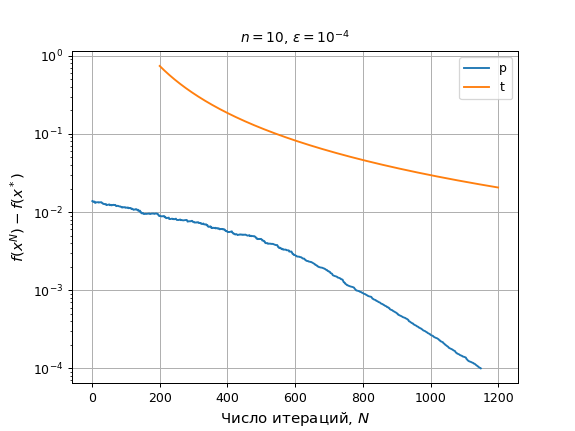

In [19]:
%matplotlib notebook
import matplotlib.pyplot as plt
plt.grid(True)
plt.plot(range(1, k+1), plt1, label = 'p')
plt.plot(range(200, 1200), [ 16*Vx0*C_const*L/k/k for k in range(200, 1200)], label='t')
plt.yscale('log')
#plt.xscale('log')
plt.xlabel(r"Число итераций, $N$", fontsize=12)
plt.ylabel(r"$f(x^N)- f(x^*) $", fontsize=12)
plt.title(r"$n = 10, \, \varepsilon = 10^{-4}$", fontsize = 11);
#plt.ticklabel_format(style='sci', axis='y', scilimits=(-2, 2))
plt.legend()

<IPython.core.display.Javascript object>


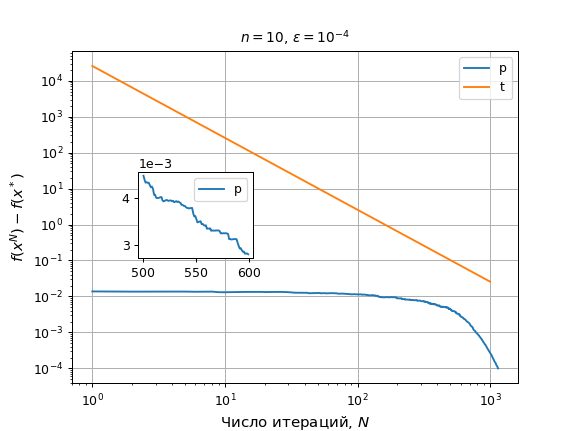

  adjustable: [ 'box' | 'datalim' | 'box-forced'] 
  agg_filter: a filter function, which takes a (m, n, 3) float array and a dpi value, and returns a (m, n, 3) array 
  alpha: float (0.0 transparent through 1.0 opaque) 
  anchor: [ 'C' | 'SW' | 'S' | 'SE' | 'E' | 'NE' | 'N' | 'NW' | 'W' ] 
  animated: bool 
  aspect: unknown
  autoscale_on: bool
  autoscalex_on: bool
  autoscaley_on: bool
  axes_locator: a callable object which takes an axes instance and renderer and returns a bbox.
  axisbelow: [ bool | 'line' ]
  clip_box: a `~.Bbox` instance 
  clip_on: bool 
  clip_path: [(`~matplotlib.path.Path`, `~.Transform`) | `~.Patch` | None] 
  color_cycle: unknown
  contains: a callable function 
  facecolor: color
  fc: color
  figure: `~.Figure`
  frame_on: bool
  gid: an id string 
  label: object 
  navigate: bool
  navigate_mode: unknown
  path_effects: `~.AbstractPathEffect` 
  picker: [None | bool | float | callable] 
  position: unknown
  rasterization_zorder: float or None 
  rast

In [20]:
%matplotlib notebook
import matplotlib.pyplot as plt
plt.grid(True)
plt.plot(range(1, k+1), plt1, label = 'p')
plt.plot(range(1, 1000), [16*int(Vx0)*C_const*L/k/k for k in range(1, 1000)], label='t')
plt.yscale('log')
plt.xscale('log')
plt.xlabel(r"Число итераций, $N$", fontsize=12)
plt.ylabel(r"$f(x^N) - f(x^*) $", fontsize=12)
plt.title(r"$n = 10, \, \varepsilon = 10^{-4}$", fontsize = 11)
#plt.ticklabel_format(style='sci', axis='y', scilimits=(-2, 2))
plt.legend()

# Generate data for the zoomed portion
X_detail = range(500, 600)
Y_detail = [plt1[y] for y in X_detail]

 # location for the zoomed portion 
sub_axes = plt.axes([0.24, 0.4, 0.2, 0.2]) 

# plot the zoomed portion
sub_axes.plot(X_detail, Y_detail, label = 'p')#, c = 'k') 
sub_axes.ticklabel_format(style='sci', axis='y', scilimits=(-2, 2))
sub_axes.legend()

# insert the zoomed figure
plt.setp(sub_axes)

plt.show()